<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_4_backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 4: Training for Tabular Data**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 4 Material

* Part 4.1: Encoding a Feature Vector for Keras Deep Learning [[Video]](https://www.youtube.com/watch?v=Vxz-gfs9nMQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_1_feature_encode.ipynb)
* Part 4.2: Keras Multiclass Classification for Deep Neural Networks with ROC and AUC [[Video]](https://www.youtube.com/watch?v=-f3bg9dLMks&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_2_multi_class.ipynb)
* Part 4.3: Keras Regression for Deep Neural Networks with RMSE [[Video]](https://www.youtube.com/watch?v=wNhBUC6X5-E&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_3_regression.ipynb)
* **Part 4.4: Backpropagation, Nesterov Momentum, and ADAM Neural Network Training** [[Video]](https://www.youtube.com/watch?v=VbDg8aBgpck&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_4_backprop.ipynb)
* Part 4.5: Neural Network RMSE and Log Loss Error Calculation from Scratch [[Video]](https://www.youtube.com/watch?v=wmQX1t2PHJc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_04_5_rmse_logloss.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running and maps Google Drive if needed.  We also initialize the PyTorch device to either GPU (if available) or CPU and include any needed functions from previous modules.

In [1]:
import torch
import copy

try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Early stopping (see Module 3.4)
class EarlyStopping():
  def __init__(self, patience=5, min_delta=1e-2, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""
    
  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss < self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

# Regression chart. (see Module 4.3)
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y.flatten()})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Make use of a GPU if one is available. (see Module 3.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Note: using Google CoLab
Using device: cpu


# Part 4.4: Training Neural Networks

Backpropagation [[Cite:rumelhart1986learning]](https://www.iro.umontreal.ca/~vincentp/ift3395/lectures/backprop_old.pdf) is one of the most common methods for training a neural network. Rumelhart, Hinton, & Williams introduced backpropagation, and it remains popular today. Programmers frequently train deep neural networks with backpropagation because it scales really well when run on graphical processing units (GPUs). To understand this algorithm for neural networks, we must examine how to train it as well as how it processes a pattern.

Researchers have extended classic backpropagation and modified to give rise to many different training algorithms. This section will discuss the most commonly used training algorithms for neural networks. We begin with classic backpropagation and end the chapter with stochastic gradient descent (SGD).

Backpropagation is the primary means of determining a neural network's weights during training. Backpropagation works by calculating a weight change amount ($v_t$) for every weight($\theta$, theta) in the neural network. This value is subtracted from every weight by the following equation: 

$$ \theta_t = \theta_{t-1} - v_t $$

We repeat this process for every iteration($t$). The training algorithm determines how we calculate the weight change. Classic backpropagation calculates a gradient ($\nabla$, nabla) for every weight in the neural network for the neural network's error function ($J$). We scale the gradient by a learning rate ($\eta$, eta).

$$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) $$

The learning rate is an important concept for backpropagation training. Setting the learning rate can be complex:

* Too low a learning rate will usually converge to a reasonable solution; however, the process will be prolonged.
* Too high of a learning rate will either fail outright or converge to a higher error than a better learning rate.

Common values for learning rate are: 0.1, 0.01, 0.001, etc.

Backpropagation is a gradient descent type, and many texts will use these two terms interchangeably. Gradient descent refers to calculating a gradient on each weight in the neural network for each training element. Because the neural network will not output the expected value for a training element, the gradient of each weight will indicate how to modify each weight to achieve the expected output. If the neural network did output exactly what was expected, the gradient for each weight would be 0, indicating that no change to the weight is necessary.

The gradient is the derivative of the error function at the weight's current value. The error function measures the distance of the neural network's output from the expected output. We can use gradient descent, a process in which each weight's gradient value can reach even lower values of the error function. 
  
The gradient is the partial derivative of each weight in the neural network concerning the error function. Each weight has a gradient that is the slope of the error function. Weight is a connection between two neurons. Calculating the gradient of the error function allows the training method to determine whether it should increase or decrease the weight. In turn, this determination will decrease the error of the neural network. The error is the difference between the expected output and actual output of the neural network. Many different training methods called propagation-training algorithms utilize gradients. In all of them, the sign of the gradient tells the neural network the following information:

* Zero gradient - The weight does not contribute to the neural network's error.
* Negative gradient - The algorithm should increase the weight to lower error.
* Positive gradient - The algorithm should decrease the weight to lower error.


Because many algorithms depend on gradient calculation, we will begin with an analysis of this process. First of all, let's examine the gradient. Essentially, training is a search for the set of weights that will cause the neural network to have the lowest error for a training set. If we had infinite computation resources, we would try every possible combination of weights to determine the one that provided the lowest error during the training. 

Because we do not have unlimited computing resources, we have to use some shortcuts to prevent the need to examine every possible weight combination. These training methods utilize clever techniques to avoid performing a brute-force search of all weight values. This type of exhaustive search would be impossible because even small networks have an infinite number of weight combinations.

Consider a chart that shows the error of a neural network for each possible weight. Figure 4.DRV is a graph that demonstrates the error for a single weight:

**Figure 4.DRV: Derivative**
![Derivative](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_2_deriv.png "Derivative")

Looking at this chart, you can easily see that the optimal weight is where the line has the lowest y-value. The problem is that we see only the error for the current value of the weight; we do not see the entire graph because that process would require an exhaustive search. However, we can determine the slope of the error curve at a particular weight. In the above chart, we see the slope of the error curve at 1.5. The straight line barely touches the error curve at 1.5 gives the slope. In this case, the slope, or gradient, is -0.5622. The negative slope indicates that an increase in the weight will lower the error.
The gradient is the instantaneous slope of the error function at the specified weight. The derivative of the error curve at that point gives the gradient. This line tells us the steepness of the error function at the given weight.  
Derivatives are one of the most fundamental concepts in calculus. For this book, you need to understand that a derivative provides the slope of a function at a specific point. A training technique and this slope can give you the information to adjust the weight for a lower error. Using our working definition of the gradient, we will show how to calculate it.

## Momentum Backpropagation

Momentum adds another term to the calculation of $v_t$:

$$ v_t = \eta \nabla_{\theta_{t-1}} J(\theta_{t-1}) + \lambda v_{t-1} $$

Like the learning rate, momentum adds another training parameter that scales the effect of momentum. Momentum backpropagation has two training parameters: learning rate ($\eta$, eta) and momentum ($\lambda$, lambda). Momentum adds the scaled value of the previous weight change amount ($v_{t-1}$) to the current weight change amount($v_t$).

This technique has the effect of adding additional force behind the direction a weight is moving. Figure 4.MTM shows how this might allow the weight to escape local minima.

**Figure 4.MTM: Momentum**
![Momentum](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_momentum.png "Momentum")

A typical value for momentum is 0.9.


## Batch and Online Backpropagation

How often should the weights of a neural network be updated?  We can calculate gradients for a training set element.  These gradients can also be summed together into batches, and the weights updated once per batch.

* **Online Training** - Update the weights based on gradients calculated from a single training set element.
* **Batch Training** - Update the weights based on the sum of the gradients over all training set elements.
* **Batch Size** - Update the weights based on the sum of some batch size of training set elements.
* **Mini-Batch Training** - The same as batch size, but with minimal batch size.  Mini-batches are very popular, often in the 32-64 element range.

Because the batch size is smaller than the full training set size, it may take several batches to make it completely through the training set.  

* **Step/Iteration** - The number of processed batches.
* **Epoch** - The number of times the algorithm processed the complete training set.

## Stochastic Gradient Descent

Stochastic gradient descent (SGD) is currently one of the most popular neural network training algorithms.  It works very similarly to Batch/Mini-Batch training, except that the batches are made up of a random set of training elements.

This technique leads to a very irregular convergence in error during training, as shown in Figure 4.SGD.

**Figure 4.SGD: SGD Error**
![SGD Error](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_5_sgd_error.png "SGD Error")
[Image from Wikipedia](https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

Because the neural network is trained on a random sample of the complete training set each time, the error does not make a smooth transition downward.  However, the error usually does go down.

Advantages to SGD include:

* Computationally efficient.  Each training step can be relatively fast, even with a huge training set.
* Decreases overfitting by focusing on only a portion of the training set each step.


## Other Techniques

One problem with simple backpropagation training algorithms is that they are susceptible to learning rate and momentum. This technique is difficult because:

* Learning rate must be adjusted to a small enough level to train an accurate neural network.
* Momentum must be large enough to overcome local minima yet small enough not to destabilize the training.
* A single learning rate/momentum is often not good enough for the entire training process. It is often helpful to automatically decrease the learning rate as the training progresses.
* All weights share a single learning rate/momentum.

Other training techniques:

* **Resilient Propagation** - Use only the magnitude of the gradient and allow each neuron to learn at its rate. There is no need for learning rate/momentum; however, it only works in full batch mode.
* **Nesterov accelerated gradient** - Helps mitigate the risk of choosing a bad mini-batch.
* **Adagrad** - Allows an automatically decaying per-weight learning rate and momentum concept.
* **Adadelta** - Extension of Adagrad that seeks to reduce its aggressive, monotonically decreasing learning rate.
* **Non-Gradient Methods** - Non-gradient methods can *sometimes* be useful, though rarely outperform gradient-based backpropagation methods.  These include: [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing), [genetic algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm), [particle swarm optimization](https://en.wikipedia.org/wiki/Particle_swarm_optimization), [Nelder Mead](https://en.wikipedia.org/wiki/Nelder%E2%80%93Mead_method), and [many more](https://en.wikipedia.org/wiki/Category:Optimization_algorithms_and_methods).

## ADAM Update

ADAM is the first training algorithm you should try.  It is very effective.  Kingma and Ba (2014) introduced the Adam update rule that derives its name from the adaptive moment estimates. [[Cite:kingma2014adam]](https://arxiv.org/abs/1412.6980)  Adam estimates the first (mean) and second (variance) moments to determine the weight corrections.  Adam begins with an exponentially decaying average of past gradients (m):

$$ m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t $$

This average accomplishes a similar goal as classic momentum update; however, its value is calculated automatically based on the current gradient ($g_t$).  The update rule then calculates the second moment ($v_t$):

$$ v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2 $$

The values $m_t$ and $v_t$ are estimates of the gradients' first moment (the mean) and the second moment (the uncentered variance).  However, they will be strongly biased towards zero in the initial training cycles.  The first moment’s bias is corrected as follows.

$$ \hat{m}_t = \frac{m_t}{1-\beta^t_1} $$

Similarly, the second moment is also corrected:

$$ \hat{v}_t = \frac{v_t}{1-\beta_2^t} $$

These bias-corrected first and second moment estimates are applied to the ultimate Adam update rule, as follows:

$$ \theta_t = \theta_{t-1} - \frac{\alpha \cdot \hat{m}_t}{\sqrt{\hat{v}_t}+\eta} \hat{m}_t $$

Adam is very tolerant to initial learning rate (\alpha) and other training parameters. Kingma and Ba (2014)  propose default values of 0.9 for $\beta_1$, 0.999 for $\beta_2$, and 10-8 for $\eta$.

## Methods Compared

The following image shows how each of these algorithms train. It is animated, so it is not displayed in the printed book, but can be accessed from here: [https://bit.ly/3kykkbn](https://bit.ly/3kykkbn).

![Training Techniques](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/contours_evaluation_optimizers.gif "Training Techniques")
Image credits: [Alec Radford](https://scholar.google.com/citations?user=dOad5HoAAAAJ&hl=en)

## Specifying the Update Rule in PyTorch

TensorFlow allows the update rule to be set to one of:

* Adagrad
* **Adam**
* Ftrl
* Momentum
* RMSProp
* **SGD**

Epoch: 1, tloss: 422.1683654785156, vloss: 368.071625, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 174.93it/s]
Epoch: 2, tloss: 118.83221435546875, vloss: 184.881088, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 204.26it/s]
Epoch: 3, tloss: 48.56353759765625, vloss: 98.987411, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 205.18it/s]
Epoch: 4, tloss: 88.35760498046875, vloss: 58.690544, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 193.17it/s]
Epoch: 5, tloss: 25.140180587768555, vloss: 39.953678, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 165.04it/s]
Epoch: 6, tloss: 28.64287757873535, vloss: 29.082977, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 193.96it/s]
Epoch: 7, tloss: 20.488361358642578, vloss: 22.190884, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 129.73it/s]
Epoch: 8, tloss: 15.721875190734863, vloss: 18.023527, EStop:[0/5]: 100%|██████████| 94/94 [00:00<00:00, 219.85it/s]
Epoch: 9, tloss: 14.510075569152832, vloss: 15.593664, EStop:[0/5]

Final score (MSE): 0.6018675565719604
Final score (RMSE): 0.7758012413978577


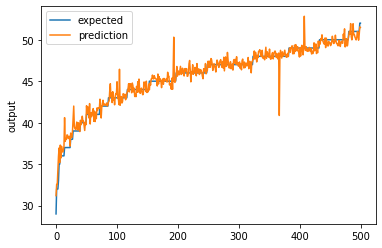

In [2]:
%matplotlib inline

import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import tqdm
import time

# Read the data set
df = pd.read_csv(
    "https://data.heatonresearch.com/data/t81-558/jh-simple-dataset.csv",
    na_values=['NA','?'])

# Generate dummies for job
df = pd.concat([df,pd.get_dummies(df['job'],prefix="job")],axis=1)
df.drop('job', axis=1, inplace=True)

# Generate dummies for area
df = pd.concat([df,pd.get_dummies(df['area'],prefix="area")],axis=1)
df.drop('area', axis=1, inplace=True)

# Generate dummies for product
df = pd.concat([df,pd.get_dummies(df['product'],prefix="product")],axis=1)
df.drop('product', axis=1, inplace=True)

# Missing values for income
med = df['income'].median()
df['income'] = df['income'].fillna(med)

# Standardize ranges
df['income'] = zscore(df['income'])
df['aspect'] = zscore(df['aspect'])
df['save_rate'] = zscore(df['save_rate'])
df['subscriptions'] = zscore(df['subscriptions'])

# Convert to numpy - Classification
x_columns = df.columns.drop('age').drop('id')
x = df[x_columns].values
y = df['age'].values

# Define the PyTorch Neural Network
class Net(nn.Module):
    def __init__(self, in_count, out_count):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, out_count)
        #self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #return self.softmax(self.fc3(x))
        return self.fc3(x)

# Split into validation and training sets
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=42)

# Numpy to Torch Tensor
x_train = torch.Tensor(x_train).float()
y_train = torch.Tensor(y_train).float()

x_test = torch.Tensor(x_test).float().to(device)
y_test = torch.Tensor(y_test).float().to(device)


# Create datasets
BATCH_SIZE = 16

dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train,\
  batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test,\
  batch_size=BATCH_SIZE, shuffle=True)


# Create model
model = Net(x.shape[1],1).to(device)

# Define the loss function for regression
loss_fn = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters())

es = EarlyStopping()

epoch = 0
done = False
while epoch<1000 and not done:
  epoch += 1
  steps = list(enumerate(dataloader_train))
  pbar = tqdm.tqdm(steps)
  model.train()
  for i, (x_batch, y_batch) in pbar:
    y_batch_pred = model(x_batch.to(device)).flatten()
    loss = loss_fn(y_batch_pred, y_batch.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss, current = loss.item(), (i + 1)* len(x_batch)
    if i == len(steps)-1:
      model.eval()
      pred = model(x_test).flatten()
      vloss = loss_fn(pred, y_test)
      if es(model,vloss): done = True
      pbar.set_description(f"Epoch: {epoch}, tloss: {loss}, vloss: {vloss:>7f}, EStop:[{es.status}]")
    else:
      pbar.set_description(f"Epoch: {epoch}, tloss {loss:}")

# Predict
pred = model(x_test)

# Measure MSE error.  
score = metrics.mean_squared_error(pred.cpu().detach(),y_test.cpu())
print("Final score (MSE): {}".format(score))

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred.cpu().detach(),y_test.cpu().detach()))
print("Final score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred.flatten().cpu().detach(),y_test.cpu().detach())